In [1]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import mean_absolute_error
import xgboost
from xgboost import XGBRegressor
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import datetime

In [60]:
df.columns

Index(['ANS Oil Price_30dayrolling_of_2yearago',
       'Total Cash Costs_90dayrolling_of_1yearago',
       'IPC_30dayrolling_of_2yearago',
       'ANS Oil Price_90dayrolling_of_3yearago',
       'IPC_30dayrolling_of_3yearago',
       'Capex GWO_30dayrolling_of_3yearaverage',
       'Production_30dayrolling_of_3yearago', 'Capex GPO_3yearago',
       'Total Cash Costs_30dayrolling_of_3yearaverage',
       'Production_30dayrolling_of_2yearago',
       'IPC_30dayrolling_of_3yearaverage',
       'ANS Oil Price_90dayrolling_of_2yearago',
       'ANS Oil Price_30dayrolling_of_3yearago',
       'Production Costs - Revex_90dayrolling_of_2yearago',
       'Capex GPO_2yearago',
       'Capex Other_3Yearsago30dayPercentChangeinRolling', 'Date',
       'Total Deferrals'],
      dtype='object')

In [59]:
clmns

{'ANS Oil Price_30dayrolling_of_2yearago',
 'ANS Oil Price_30dayrolling_of_3yearago',
 'ANS Oil Price_90dayrolling_of_2yearago',
 'ANS Oil Price_90dayrolling_of_3yearago',
 'Capex GWO_30dayrolling_of_3yearaverage',
 'Date',
 'IPC_30dayrolling_of_2yearago',
 'IPC_30dayrolling_of_3yearago',
 'IPC_30dayrolling_of_3yearaverage',
 'Production Costs - Revex_90dayrolling_of_2yearago',
 'Production_30dayrolling_of_2yearago',
 'Production_30dayrolling_of_3yearago',
 'Total Cash Costs_30dayrolling_of_3yearaverage',
 'Total Cash Costs_90dayrolling_of_1yearago',
 'Total Deferrals'}

In [2]:
df = pd.read_excel('C:\\Users\\lemkp0\\OneDrive - BP\\Documents\\Alaska_forecasting\\Deferrals.xlsx')
years = list(set(pd.to_datetime(df['Date']).dt.year))
clmns = list(df.columns)
for year in years:
    df_temp = df[df['Date'].dt.year == year]
    df_temp = df.replace(0, np.nan)
    df_temp = df_temp.dropna(axis='columns', thresh=int(len(df_temp.index)*3/4))
    clmns = set.intersection(set(clmns), set(list(df_temp.columns)))
df = df[list(clmns)]   
df_test = df[df['Date']>datetime.date(2016,12,31)]
X_test = df_test.drop(columns=['Total Deferrals','Date'])
Y_test = df_test['Total Deferrals']
df_train = df[df['Date']<datetime.date(2016,10,1)] 
X_train = df_train.drop(columns=['Total Deferrals','Date'])
Y_train = df_train['Total Deferrals'] 

In [3]:
X_train

,ANS Oil Price_90dayrolling_of_3yearago,Total Cash Costs_30dayrolling_of_3yearaverage,ANS Oil Price_90dayrolling_of_2yearago,Production_30dayrolling_of_3yearago,Total Capex_LastYear90dayPercentChangeinRolling,IPC_30dayrolling_of_3yearago
0,0.452667,0.812282,0.452667,11644.466667,-19.429433,16011.133333
1,0.905333,0.803119,0.905333,23093.500000,-19.271962,31826.833333
2,1.358000,0.793956,1.358000,34622.900000,-19.113982,47456.233333
3,1.838111,0.784793,1.838111,45113.933333,-18.955493,62947.266667
4,2.315667,0.775630,2.315667,53993.400000,-18.796491,78426.733333
5,2.727111,0.766468,2.727111,64083.700000,-18.636974,93917.033333
6,3.128222,0.757305,3.128222,77166.033333,-18.476940,109832.700000
7,3.519667,0.748142,3.519667,91374.333333,-18.316385,125041.000000
8,3.911111,0.738979,3.911111,105832.733333,-18.155308,140166.066667
9,4.302556,0.729816,4.302556,120873.133333,-17.993706,155673.133333


In [11]:
# should parameter tune: colsample_bytree, colsample_bylevel, eta, 

p_grid = { 'max_depth':[27],
         'min_child_weight':[5],
         'gamma': [.01],
         'learning_rate': [.5],
         'subsample': [0.9],
          'colsample_bytree': [0.01,0.1,0.5,0.9],
          'colsample_bylevel': [0.01,0.1,0.5,0.9]
         }

In [13]:
%%time
model = XGBRegressor(booster='dart', rate_drop=0.1, objective = 'reg:tweedie', eval_metric='mae', tweedie_variance_power=1.5, seed=1234)

inner_cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1234)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1234)

# innercv
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv, refit=True)
clf.fit(X_train, Y_train)
print(clf.best_score_)
print(mean_absolute_error(Y_train, clf.predict(X_train)))
print(clf.best_params_)
# outercv
nested_score = cross_val_score(clf, X=X_test, y=Y_test, cv=outer_cv)
print(nested_score.mean())
corrl = np.corrcoef(Y_test, clf.predict(X_test))[0, 1]
print(corrl)
print(mean_absolute_error(Y_test, clf.predict(X_test)))


0.2430796181233896
5750.74184344674
{'colsample_bylevel': 0.01, 'colsample_bytree': 0.9, 'gamma': 0.01, 'learning_rate': 0.5, 'max_depth': 27, 'min_child_weight': 5, 'subsample': 0.9}
-3.099612367745303
-0.04866604105047911
2119.3869254438846
Wall time: 2h 29min 15s


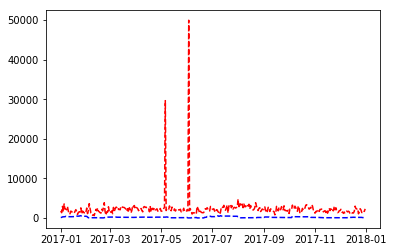

In [14]:
plt.plot(df_test['Date'], Y_test, 'r--', df_test['Date'], clf.predict(X_test), 'b--')
plt.show()

In [65]:
0.2495849226344596
{'gamma': 0.01, 'learning_rate': 0.5, 'max_depth': 17, 'min_child_weight': 5}
-3.9678072661161097
0.004887613516633985
Wall time: 1d 5h 43min 23s

corrl = np.corrcoef(Y_test, clf.predict(X_test))[0, 1]
print(corrl)

0.05166533041761445


In [ ]:
%%time
model = XGBRegressor(booster='dart', objective = 'reg:linear', eval_metric='mae', seed=1234)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    inner_cv = LeaveOneOut()
    outer_cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1234)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()

In [23]:
model.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'rate_drop', 'eval_metric'])

In [21]:
print(xgboost.__version__)

0.72
